In [1]:
%load_ext autoreload
import sys
sys.path.append('..')

In [11]:
%autoreload

from scipy.stats import spearmanr
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

import matplotlib, matplotlib.pyplot as plt
%matplotlib inline

import os, pickle, time, random, numpy as np

# Clustering Text Examples

In [7]:
RAW_FILEPATH = '/crimea/graph_augmented_pt/synthetic_datasets/wikisent2.txt'
PKL_FILEPATH = '/crimea/graph_augmented_pt/synthetic_datasets/wikisent2_feat.pkl'

SUBSAMPLE_FILEPATH_TEXT    = '/crimea/graph_augmented_pt/synthetic_datasets/wikisent2_small.txt'
SUBSAMPLE_FILEPATH_DERIVED = '/crimea/graph_augmented_pt/synthetic_datasets/wikisent2_feat_small.pkl'

In [3]:
assert os.path.isfile(RAW_FILEPATH)

# Source: https://www.kaggle.com/mikeortman/wikipedia-sentences
with open(RAW_FILEPATH, mode='r') as f: text_data = f.readlines()

if os.path.isfile(PKL_FILEPATH):
    with open(PKL_FILEPATH, mode='rb') as f:
        # This is inconsistent as I never saved CV initially and haven't re-generated it.
        X, LDA, topics, first_topic, sents_by_topic, topics_correlation = pickle.load(f)
else:
    CV = CountVectorizer(ngram_range=(1, 1), max_df=0.7, min_df=100)
    X = CV.fit_transform(text_data)
    
    LDA = LatentDirichletAllocation(
        n_components=100, random_state=1, verbose=1
    )

    topics = LDA.fit_transform(X)
    topics_correlation = spearmanr(topics, axis=0)
    assert topics_correlation.correlation.shape == (100, 100)
    
    first_topic = topics.argmax(axis=1)
    
    sents_by_topic = {i: [] for i in range(100)}
    for i, (t, all_p, sent) in enumerate(zip(first_topic, topics, text_data)):
        sents_by_topic[t].append((sent, all_p[t], i))

put_dir / 'models.pkl', mode='wb') as f:
#             pickle.dum
    with open(PKL_FILEPATH, mode='wb') as f:
        pickle.dump((X, LDA, topics, first_topic, sents_by_topic, topics_correlation.correlation, CV), f)

In [14]:
orig_st = time.time()
with open(RAW_FILEPATH, mode='r') as f: text_data = f.readlines()
with open(PKL_FILEPATH, mode='rb') as f:
    X, LDA, topics, first_topic, sents_by_topic, topic_correlations = pickle.load(f)
orig_end = time.time()

random.seed(11)

subsample_cnt = 150000
idxs = np.arange(len(topics))
random.shuffle(idxs)

idxs = idxs[:subsample_cnt]

text_data_small      = np.array(text_data)[idxs]
X_small              = X[idxs]
topics_small         = np.array(topics)[idxs]
first_topic_small    = np.array(first_topic)[idxs]
sents_by_topic_small = {i: [] for i in range(100)}
for i, (t, all_p, sent) in enumerate(zip(first_topic_small, topics_small, text_data_small)):
    sents_by_topic_small[t].append((sent, all_p[t], i))
for t in range(100):
    sents_by_topic_small[t] = sorted(sents_by_topic_small[t], key=lambda x: x[1], reverse=True)

SUBSAMPLE_FILEPATH_TEXT    = '/crimea/graph_augmented_pt/synthetic_datasets/wikisent2_small.txt'
SUBSAMPLE_FILEPATH_DERIVED = '/crimea/graph_augmented_pt/synthetic_datasets/wikisent2_feat_small.pkl'
with open(SUBSAMPLE_FILEPATH_TEXT, mode='w') as f: f.write('\n'.join(text_data_small))
with open(SUBSAMPLE_FILEPATH_DERIVED, mode='wb') as f:
    pickle.dump((X_small, LDA, topics_small, first_topic_small, sents_by_topic_small, topic_correlations), f)
    
subsamp_st = time.time()
with open(SUBSAMPLE_FILEPATH_TEXT, mode='r') as f: text_data_small = f.readlines()
with open(SUBSAMPLE_FILEPATH_DERIVED, mode='rb') as f:
    X_small, LDA, topics_small, first_topic_small, sents_by_topic_small, topic_correlations = pickle.load(f)
subsamp_end = time.time()

print(f"Original took {(orig_end - orig_st)/60} minutes. Subsampled took {(subsamp_end - subsamp_st)/60}")

Original took 0.18476757605870564 minutes. Subsampled took 0.052020800113677976


In [ ]:
random.seed(11)

subsample_cnt = 15000
idxs = np.arange(len(topics))
random.shuffle(idxs)

idxs = idxs[:subsample_cnt]

X_small              = X[idxs]
topics_small         = np.array(topics)[idxs]
first_topic_small    = np.array(first_topic)[idxs]
sents_by_topic_small = np.array(sents_by_topic)[idxs]



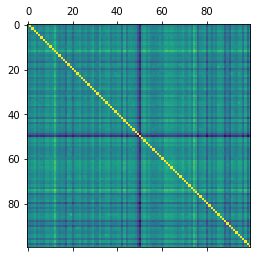

In [15]:
plt.matshow(topics_correlation.correlation)

In [54]:
if 'CV' in globals():
    vocab = CV.get_feature_names()
    for t in range(100):
        print(f"Topic {t}: {', '.join([vocab[i] for i in LDA.components_[t].argsort()[:-18:-1]])}")

        for s, p, i in sents_by_topic[t][:5]:
            s = s.strip()
            s = (s[:87] + '...') if len(s) > 90 else s
            print(f"  {i} ({100.0*p:.1f}%): {s}")
        print()

Topic 0: in, company, founded, was, san, based, and, los, texas, angeles, by, is, al, california, francisco, inc, headquartered
  5321830 (93.4%): Techwell Inc. was a fabless semiconductor company founded in 1997, that was based in Sa...
  342210 (93.4%): Amylin Pharmaceuticals was a biopharmaceutical company based in San Diego, CA, that was...
  5297901 (92.9%): Systech Corporation (Systech) is a California corporation founded in 1981 and headquart...
  3432273 (92.9%): It was founded in London in 1997, and is currently based in Boston.
  5744887 (92.4%): The company was founded in 1999 and was headquartered in Los Angeles, California.

Topic 1: over, more, 000, than, in, million, festival, and, it, of, with, at, to, worldwide, 50, stars, 500
  2521884 (94.8%): In 2009 it had over 2,800 employees and had an annual turnover of more than US$50 million.
  2513957 (94.5%): In 2007, the companies of the group had nearly 14.000 employees and a turnover of more ...
  5979813 (94.5%): The fil